Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
"

"\n// Inferring a Rate\ndata {\n  int N;\n  int<lower=0> k[N];\n  int<lower=1> n[N];\n}\nparameters {\n  real<lower=0,upper=1> theta;\n  real<lower=0,upper=1> thetaprior;\n}\nmodel {\n  // Prior Distribution for Rate Theta\n  theta ~ beta(1, 1);\n  thetaprior ~ beta(1, 1);\n\n  // Observed Counts\n  k ~ binomial(n, theta);\n}\n"

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain)
# Use 16 observations
N2 = 4^2
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2))
k2 = rand(d, N2)

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/02



16-element Array{Int64,1}:
 6
 7
 6
 5
 5
 7
 6
 7
 7
 6
 8
 6
 6
 6
 7
 8

Input data for cmdstan

In [5]:
binomialdata = [
  Dict("N" => length(n2), "n" => n2, "k" => k2)
]

1-element Array{Dict{String,Any},1}:
 Dict("N"=>16,"k"=>[6, 7, 6, 5, 5, 7, 6, 7, 7, 6, 8, 6, 6, 6, 7, 8],"n"=>[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

Sample using cmdstan

In [6]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Describe the draws
describe(chn)


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.029, 0.029, 0.027, 0.029) seconds, 0.11 seconds total
Sampling took (0.041, 0.046, 0.047, 0.045) seconds, 0.18 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -90  3.1e-02     1.2    -92   -90   -89  1.4e+03  8.0e+03  1.0e+00
accept_stat__   0.91  1.8e-03    0.12   0.64  0.95   1.0  4.7e+03  2.6e+04  1.0e+00
stepsize__      0.83  3.3e-02   0.046   0.76  0.87  0.87  2.0e+00  1.1e+01  3.1e+13
treedepth__      2.0  1.2e-02    0.64    1.0   2.0   3.0  2.9e+03  1.6e+04  1.0e+00
n_leapfrog__   

Plot the 4 chains

res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.7113509419999987, σ=0.038338337591197626)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.7113408479999999, σ=0.035983044475598476)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.714622423000001, σ=0.0379752874491039)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.7102131800000002, σ=0.03970510037649569)


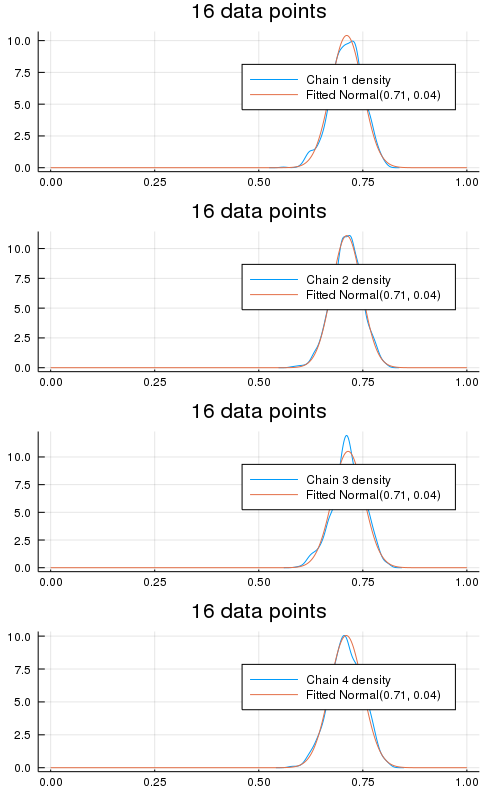

In [7]:
if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    @show res = fit_mle(Normal, vals)
    μ = round(res.μ, digits=2)
    σ = round(res.σ, digits=2)
    p[i] = density(vals, lab="Chain $i density", title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(res.μ, res.σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

##-

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*